<a href="https://colab.research.google.com/github/AyHaski/BigDataAnalyticsProject/blob/master/Kopie_von_Rapids_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big Data Analytics
Dieses Notebook wurde für das Abschluss Projekt in Big Data Analytics für die Hochschule Offenburg erstellt.

Kaggel ID: 5225680

Kaggel Username: ayhaski

Beste Leaderboard Position: 275

Notebooks die geholfen haben:

https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration

https://www.kaggle.com/ravijoe/data-cleaning-eda-modelling


# Environment Sanity Check #

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

Check the output of `!nvidia-smi` to make sure you've been allocated a Tesla T4, P4, or P100.

In [ ]:
!nvidia-smi

Sat Sep  5 11:53:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Setup:
Set up script installs
1. Install most recent Miniconda release compatible with Google Colab's Python install  (3.6.7)
1. removes incompatible files
1. Install RAPIDS libraries
1. Set necessary environment variables
1. Copy RAPIDS .so files into current working directory, a workaround for conda/colab interactions
1. If running v0.11 or higher, updates pyarrow library to 0.15.x.

In [1]:
# Install RAPIDS and Dask_ml
!pip install dask_ml
!pip install dask_cuda

!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable


import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

  Using cached dask_ml-1.6.0-py3-none-any.whl (140 kB)
  Using cached dask_glm-0.2.0-py2.py3-none-any.whl (12 kB)
  Using cached multipledispatch-0.6.0-py3-none-any.whl (11 kB)
  Using cached dask_cuda-0.15.0-py3-none-any.whl (44 kB)
fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT CHANGES: RAPIDS on Colab will be pegged to 0.14 Stable until further notice.
2. Default stable version is now 0.14.  Nightly will redirect to 0.14.
3. You can now declare your RAPIDSAI version as a CLI option and skip the user prompts (ex: '0.14' or '0.15', between 0.13 to 0.14, without the quotes): 
        "!bash rapidsai-csp-utils/colab/rapids-colab.sh <version/label>"
        Examples: '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.14', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh stable', or '!bash rapidsai-csp-utils

# Imports und Laden der Daten


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import nvstrings
import numpy as np
import cudf, cuml
import dask_cudf
import io, requests
import math
import gc
import cupy as cp

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns 

#Learning
from cuml.preprocessing.model_selection import train_test_split
from scipy.stats import uniform

# Linear Models
from cuml.linear_model import LinearRegression # Linear
from cuml.linear_model import LogisticRegression # Logisitc
from cuml.linear_model import ElasticNet # Elastic
from cuml.linear_model import Ridge # Ridge
from cuml.linear_model import Lasso # Lasso
from cuml.linear_model import MBSGDRegressor as cumlMBSGDRegressor # Mini Batch SGD Regressor

from cuml.solvers import SGD as cumlSGD # Stochastic Gradient Descent
from cuml.ensemble import RandomForestRegressor as cuRF # Random Forest
from cuml.neighbors import KNeighborsRegressor  # Nearest Neighbours
from cuml.svm import SVR # Support Vector Machines

from cuml import ForestInference
import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from cuml.metrics.regression import r2_score
from cuml.metrics.accuracy import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score as sk_acc
from sklearn.utils.fixes import loguniform

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: nvstrings will be removed in 0.15. Please use equivalent from libcudf
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
cudf.set_allocator("managed")
base_path='/content/drive/My Drive/bigData'

traintypes = {'fare_amount': 'float32',
              'pickup_datetime':'str',
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'int8'}

cols = list(traintypes.keys())
usecols = cols

In [4]:
%%time
test_1 = cudf.read_csv(base_path +'/test.csv', usecols=cols, dtype=traintypes, nrows=25000000)
train_1 = cudf.read_csv(base_path +'/train.csv', usecols=cols, dtype=traintypes, nrows=25000000)

CPU times: user 2.44 s, sys: 2.52 s, total: 4.96 s
Wall time: 1min 22s


In [45]:
train_1.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844307,40.721321,-73.841614,40.712273,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982742,40.761269,-73.991234,40.750565,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987137,40.733139,-73.991570,40.758095,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968102,40.768009,-73.956665,40.783768,1


In [5]:
train_1['pickup_datetime'] = train_1['pickup_datetime'].astype('datetime64[ns]')
test_1['pickup_datetime'] = test_1['pickup_datetime'].astype('datetime64[ns]')

In [6]:
#Getting integer numbers from the pickup_datetime
train_1["hour"] = train_1.pickup_datetime.dt.hour
train_1["weekday"] = train_1.pickup_datetime.dt.weekday
train_1["month"] = train_1.pickup_datetime.dt.month
train_1["year"] = train_1.pickup_datetime.dt.year

test_1["hour"] = test_1.pickup_datetime.dt.hour
test_1["weekday"] = test_1.pickup_datetime.dt.weekday
test_1["month"] = test_1.pickup_datetime.dt.month
test_1["year"] = test_1.pickup_datetime.dt.year

In [ ]:
train_1.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year
0,4.5,2009-06-15 17:26:21,-73.844307,40.721321,-73.841614,40.712273,1,17,0,6,2009
1,16.9,2010-01-05 16:52:16,-74.016045,40.711304,-73.979271,40.782005,1,16,1,1,2010
2,5.7,2011-08-18 00:35:00,-73.982742,40.761269,-73.991234,40.750565,2,0,3,8,2011
3,7.7,2012-04-21 04:30:42,-73.987137,40.733139,-73.991570,40.758095,1,4,5,4,2012
4,5.3,2010-03-09 07:51:00,-73.968102,40.768009,-73.956665,40.783768,1,7,1,3,2010


# Data Cleaning and Analysis


Bevor mit den Daten gearbeitet werden kann sollten diese betrachtet um mögliche Null Werte und Outliers zu finden und zu entfernen. So können auch schon mögliche Abhängigkeiten zwischen den Datenspalten erkannt werden.


## Null Data

In [7]:
print("Shape of Training Data",train_1.shape)
print("Shape of Testing Data",test_1.shape)

Shape of Training Data (25000000, 11)
Shape of Testing Data (9914, 10)


In [8]:
train_1.nans_to_nulls()
train_1 = train_1.dropna()
print("Shape of Training Data after removing null data",train_1.shape)
print("Shape of Testing Data after removing null datat",test_1.shape)

Shape of Training Data after removing null data (24999829, 11)
Shape of Testing Data after removing null datat (9914, 10)


In [9]:
train_1.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year
count,2.499983e+07,2.499983e+07,2.499983e+07,2.499983e+07,2.499983e+07,2.499983e+07,2.499983e+07,2.499983e+07,2.499983e+07,2.499983e+07
mean,1.134218e+01,-7.251196e+01,3.992126e+01,-7.251045e+01,3.991936e+01,1.685150e+00,1.351000e+01,3.041245e+00,6.265967e+00,2.011739e+03
std,1.574760e+01,1.297446e+01,9.572017e+00,1.291476e+01,9.568279e+00,1.309850e+00,6.517512e+00,1.948866e+00,3.435570e+00,1.860172e+00
min,-3.000000e+02,-3.439245e+03,-3.492264e+03,-3.442024e+03,-3.547886e+03,-1.270000e+02,0.000000e+00,0.000000e+00,1.000000e+00,2.009000e+03
25%,6.000000e+00,-7.399206e+01,4.073492e+01,-7.399139e+01,4.073403e+01,1.000000e+00,9.000000e+00,1.000000e+00,3.000000e+00,2.010000e+03
50%,8.500000e+00,-7.398181e+01,4.075264e+01,-7.398016e+01,4.075314e+01,1.000000e+00,1.400000e+01,3.000000e+00,6.000000e+00,2.012000e+03
75%,1.250000e+01,-7.396709e+01,4.076712e+01,-7.396368e+01,4.076809e+01,2.000000e+00,1.900000e+01,5.000000e+00,9.000000e+00,2.013000e+03
max,6.155086e+04,3.457625e+03,3.406008e+03,3.457622e+03,3.400392e+03,5.100000e+01,2.300000e+01,6.000000e+00,1.200000e+01,2.015000e+03


## Fare amount and Passenger Count

In [ ]:
fare_amount = train_1['fare_amount'].to_array()
passenger_count = train_1['passenger_count'].to_array()

Text(0.5, 1.0, 'Verteilung der Gäste')

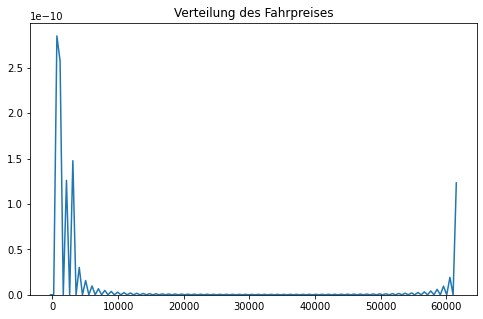

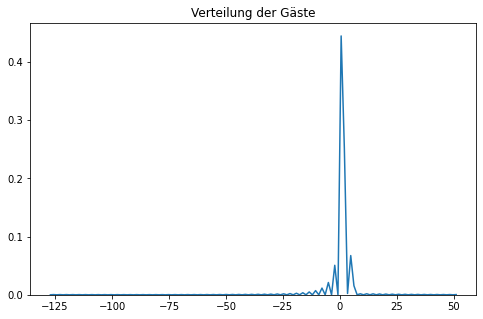

In [ ]:
plt.figure(figsize=(8,5))
sns.kdeplot(fare_amount).set_title("Verteilung des Fahrpreises")

plt.figure(figsize=(8,5))
sns.kdeplot(passenger_count).set_title("Verteilung der Gäste")

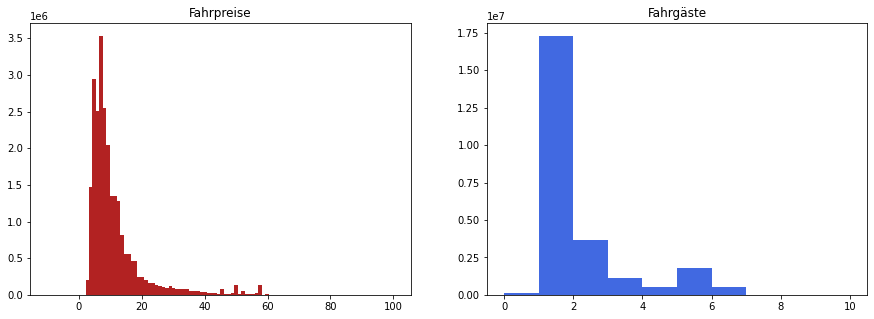

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.hist(fare_amount, bins=100, range=(-10,100), color='firebrick')
ax1.set_title('Fahrpreise')

ax2.hist(passenger_count,bins=10, range=(0,10), color='royalblue')
ax2.set_title('Fahrgäste')
plt.show()

Insgesamt sieht man durch diese Graphen das meistens 1 bis 2 Passagiere ein Taxi verwenden und das meistens die Gebühren zwischen 2 und 20 Dollar liegen. 

Von der Graphen und der Informationen kann geshen werden, das es Einträge gibt die unter 0 sind für die Fare_mount und Passenger_count. Diese Einträge könnten Fehler sein und werden entfernt, da sie das Ergebnis ins negative beeinflüssen können. Für die Passenger_Count gibt es zudem Einträge, welche über 8 Passagiere angibt, was Logistisch nicht möglich ist, so werden diese Einträge auch entfernt.

In [10]:
train_1 = train_1[(train_1['fare_amount'] > 0) & (train_1['fare_amount'] < 20000)]
train_1 = train_1[(train_1['passenger_count'] > 0) & (train_1['passenger_count'] < 9)]
print("Shape of Training Data",train_1.shape)

Shape of Training Data (24909897, 11)


## Longitude and Latitude

Als nächstes werden die Pickup und Dropoff Punkte betrachtet. Wir durch die Informationen, welche durch das .describe erhalten haben zu sehen ist, gibt es einige sehr entfernte Werte. Der Mittelpunkt von Newyork liegt bei einer Latitude 40 und Longitude -74. Also wollen wir zuerset den Bereich um New York herum betrachten






In [17]:
dropoff_long = train_1['dropoff_longitude'].to_array()
dropoff_lat = train_1['dropoff_latitude'].to_array()
pickup_long = train_1['pickup_longitude'].to_array()
pickup_lat = train_1['pickup_latitude'].to_array()

In [ ]:
city_long_border = (-75, -73)
city_lat_border = (40, 42)

(-75.0, -73.0)

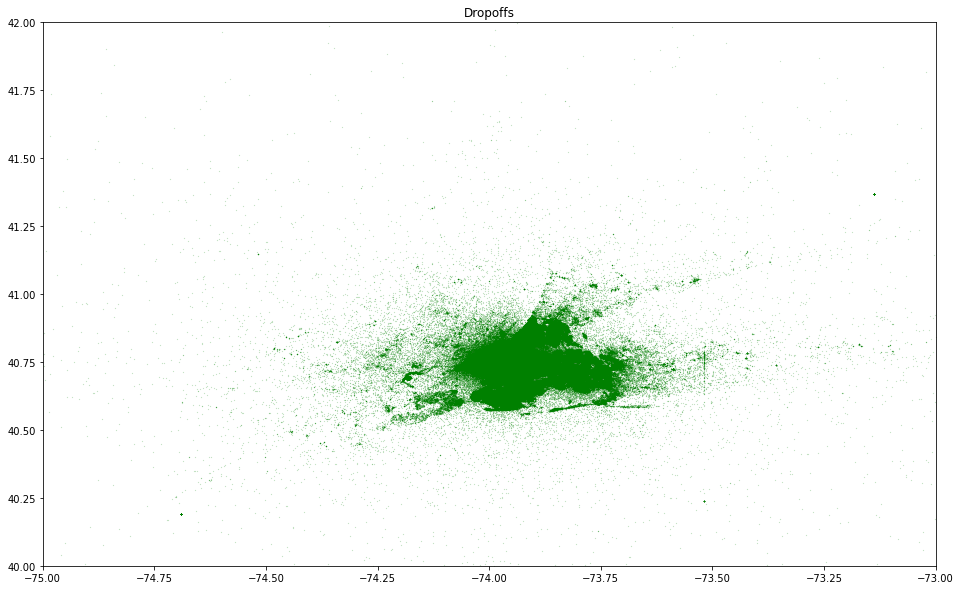

In [ ]:
plt.figure(figsize=(16,10))
plt.scatter(dropoff_long, dropoff_lat,
                color='green', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

(-75.0, -73.0)

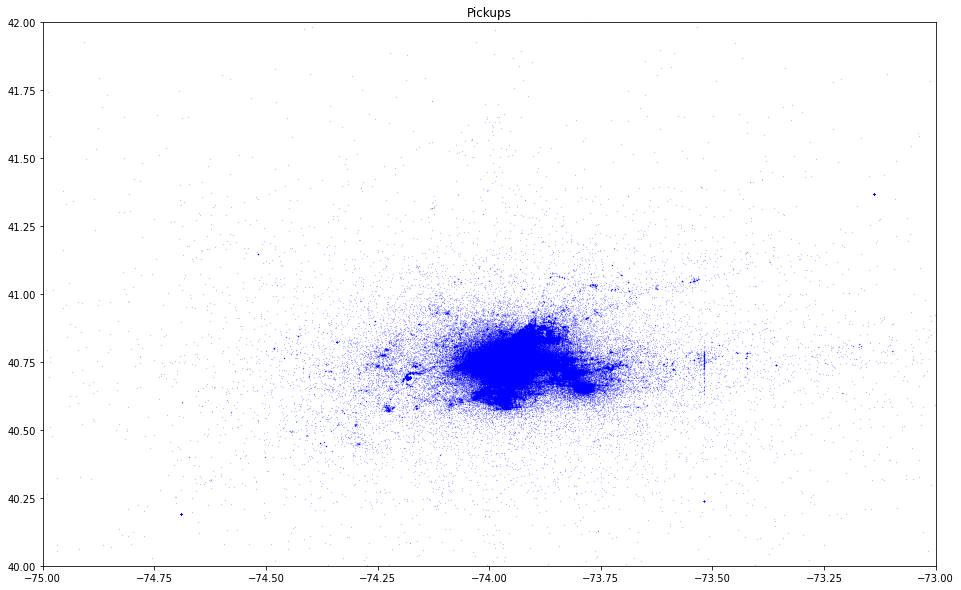

In [ ]:
plt.figure(figsize=(16,10))
plt.scatter(pickup_long, pickup_lat,
                color='blue', 
                s=.02, alpha=.6)
plt.title("Pickups")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

Die Minimalen und Maximalen Werte wurden nochmal in einer kleinen Tabelle zusammengefasst.


| Min Lat   | Max Lat   | Min Long  |  Max Long |
|:---------:| ---------:| ---------:| ---------:|
| -3492.2637| 3406.0083 |-3439.2449 | 3457.6255 |

Betrachtet man eine Heatmap der Punkte wird deutlich das es viele Punkte gibt die außerhalb von New York liegen. Daher sollten die Daten in eine Art Bounding Box eingegrenzt werden, womit das Ergebnis der Vorhersage genauer werden sollte.

Für das Eingrenzen werden die maximalen und minimalen Werte des Testsets verwendet

In [11]:
min_long = min(train_1['pickup_longitude'].min(), train_1['pickup_longitude'].min())
max_long = max(train_1['pickup_longitude'].max(), train_1['pickup_longitude'].max())

min_lat = min(train_1['pickup_latitude'].min(), train_1['pickup_latitude'].min())
max_lat = max(train_1['pickup_latitude'].max(), train_1['pickup_latitude'].max())

print ('Trainset Minimum und Maximum Longitude: ', min_long, ',', max_long)
print ('Trainset Minimum und Maximum Latitude: ', min_lat, ',', max_lat)

min_long = min(test_1['pickup_longitude'].min(), test_1['pickup_longitude'].min())
max_long = max(test_1['pickup_longitude'].max(), test_1['pickup_longitude'].max())

min_lat = min(test_1['pickup_latitude'].min(), test_1['pickup_latitude'].min())
max_lat = max(test_1['pickup_latitude'].max(), test_1['pickup_latitude'].max())

print ('Testset Minimum und Maximum Longitude: ', min_long, ',', max_long)
print ('Testset Minimum und Maximum Latitude: ', min_lat, ',', max_lat)

Trainset Minimum und Maximum Longitude:  -3439.2449 , 3457.6255
Trainset Minimum und Maximum Latitude:  -3492.2637 , 3406.0083
Testset Minimum und Maximum Longitude:  -74.25219 , -72.986534
Testset Minimum und Maximum Latitude:  40.57314 , 41.709553


In [12]:
min_long = math.floor(min_long) #-74.5
max_long = math.ceil(max_long) #-72.5
min_lat = math.floor(min_lat) #40.5
max_lat = math.ceil(max_lat)

city_long_border_zoomed = (min_long, max_long)
city_lat_border_zoomed = (min_lat, max_lat)

print ('Gerundet Testset Minimum und Maximum Longitude: ', min_long, ',', max_long)
print ('Gerundet Testset Minimum und Maximum Latitude: ', min_lat, ',', max_lat)

Gerundet Testset Minimum und Maximum Longitude:  -75 , -72
Gerundet Testset Minimum und Maximum Latitude:  40 , 42


(-75.0, -72.0)

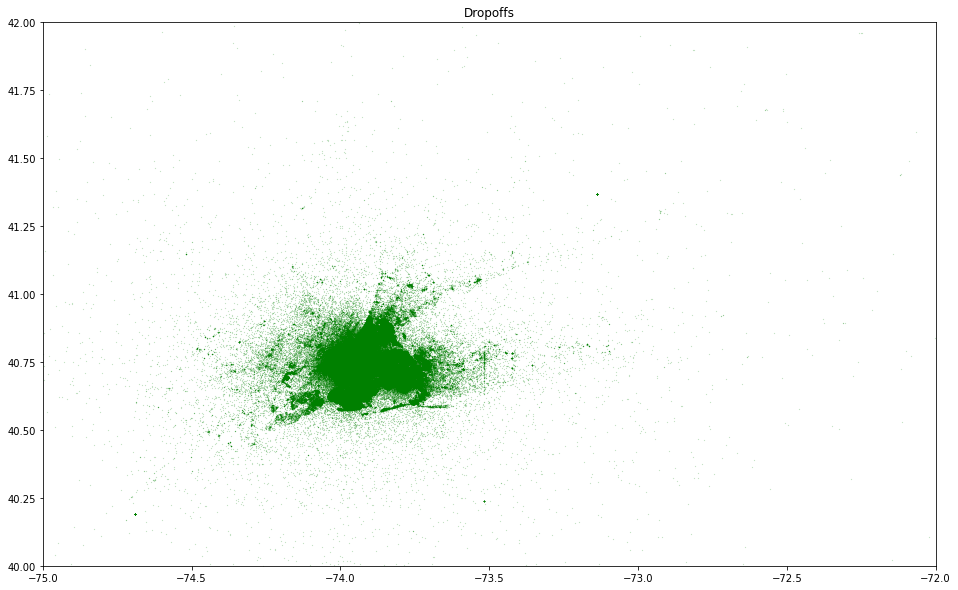

In [18]:
plt.figure(figsize=(16,10))
plt.scatter(dropoff_long, dropoff_lat,
                color='green', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.ylim(city_lat_border_zoomed)
plt.xlim(city_long_border_zoomed)

(-75.0, -72.0)

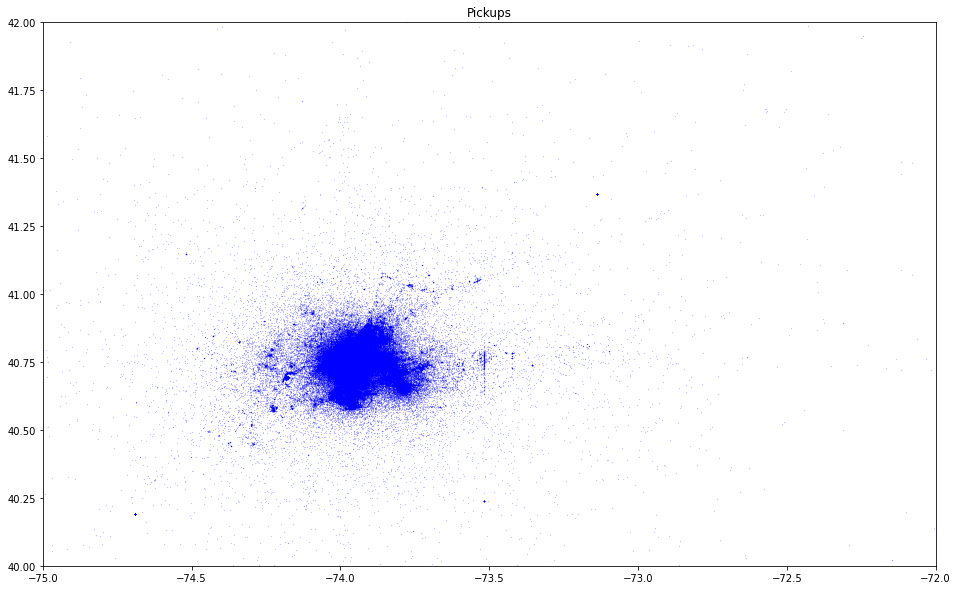

In [19]:
plt.figure(figsize=(16,10))
plt.scatter(pickup_long, pickup_lat,
                color='blue', 
                s=.02, alpha=.6)
plt.title("Pickups")

plt.ylim(city_lat_border_zoomed)
plt.xlim(city_long_border_zoomed)

Die Daten werden auf einer Longtitude von (-75, -72) und Latitude von (40, 42) eingegrenzt

In [13]:
train_1 = train_1[(train_1['pickup_longitude'] < max_long) & (train_1['pickup_longitude'] > min_long)]
train_1 = train_1[(train_1['pickup_latitude'] > min_lat) & (train_1['pickup_latitude'] < max_lat)]
train_1 = train_1[(train_1['dropoff_longitude'] < max_long) & (train_1['dropoff_longitude'] > min_long)]
train_1 = train_1[(train_1['dropoff_latitude'] > min_lat) & (train_1['dropoff_latitude'] < max_lat)]

print("Shape of Training Data after distance calculations", train_1.shape)
train_1.describe()

Shape of Training Data after distance calculations (24385888, 11)


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year
count,2.438589e+07,2.438589e+07,2.438589e+07,2.438589e+07,2.438589e+07,2.438589e+07,2.438589e+07,2.438589e+07,2.438589e+07,2.438589e+07
mean,1.132983e+01,-7.397516e+01,4.075104e+01,-7.397432e+01,4.075139e+01,1.691226e+00,1.351049e+01,3.041180e+00,6.269309e+00,2.011738e+03
std,9.733648e+00,3.914800e-02,3.003600e-02,3.835100e-02,3.322800e-02,1.306956e+00,6.516965e+00,1.949092e+00,3.436488e+00,1.865668e+00
min,1.000000e-02,-7.498994e+01,4.000234e+01,-7.499828e+01,4.000201e+01,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.009000e+03
25%,6.000000e+00,-7.399228e+01,4.073655e+01,-7.399159e+01,4.073557e+01,1.000000e+00,9.000000e+00,1.000000e+00,3.000000e+00,2.010000e+03
50%,8.500000e+00,-7.398210e+01,4.075335e+01,-7.398061e+01,4.075384e+01,1.000000e+00,1.400000e+01,3.000000e+00,6.000000e+00,2.012000e+03
75%,1.250000e+01,-7.396831e+01,4.076754e+01,-7.396536e+01,4.076839e+01,2.000000e+00,1.900000e+01,5.000000e+00,9.000000e+00,2.013000e+03
max,3.130300e+03,-7.200594e+01,4.198386e+01,-7.202303e+01,4.199811e+01,8.000000e+00,2.300000e+01,6.000000e+00,1.200000e+01,2.015000e+03


## Abhängigkeiten

Am Ende sollten die Daten noch auf verschiedene Abhängigkeiten gecheckt werden. Also wird überprüft ob die Fare_amount etwas mit der Datetime, den Passagieren und die Distanz zu tun hat.
Für das sollte muss zuerst noch die Distanz berechnet werden. Zwei verschiedene Berechnung wurden auspobiert während dem Anfang des Projekts. Einmal die absolute Distanz und einmal die Distanz mit der Haversine Formel. Bei den Anfangsversuchen mit simplere Modelle erschließte sich ein Score-Unterschied von 1-2 Punkten. Somit wurde sich letztendlich für die Harvesine Formel entschieden.  

In [21]:
fare_amount = train_1['fare_amount'].to_array()
passenger_count = train_1['passenger_count'].to_array()
hour = train_1["hour"].to_array()
weekday = train_1["weekday"].to_array()
month =train_1["month"].to_array()
year = train_1["year"].to_array()

### Distance in miles

In [14]:
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [15]:
train_1['distance_miles'] = distance(train_1['pickup_latitude'], train_1['pickup_longitude'], \
                                      train_1['dropoff_latitude'], train_1['dropoff_longitude'] )
test_1['distance_miles'] = distance(test_1['pickup_latitude'], test_1['pickup_longitude'], \
                                      test_1['dropoff_latitude'], test_1['dropoff_longitude'] )
train_1['distance_miles'].describe()

count    2.438589e+07
mean     1.861726e+00
std      2.492321e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.366828e+00
75%      2.424850e+00
max      1.211458e+02
Name: distance_miles, dtype: float64

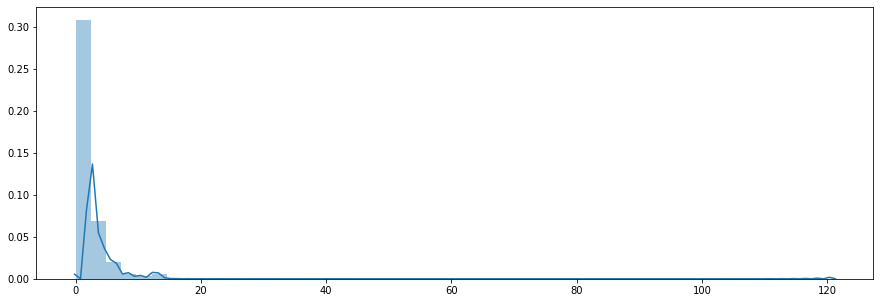

In [ ]:
distance = train_1['distance_miles'].to_array()

plt.figure(figsize=(15,5))
sns.distplot(distance)

Durch das Histogramm sieht man, das die meisten Fahrten sehr kurz sind un unter 5 Miles liegen.

Text(0, 0.5, 'Fare')

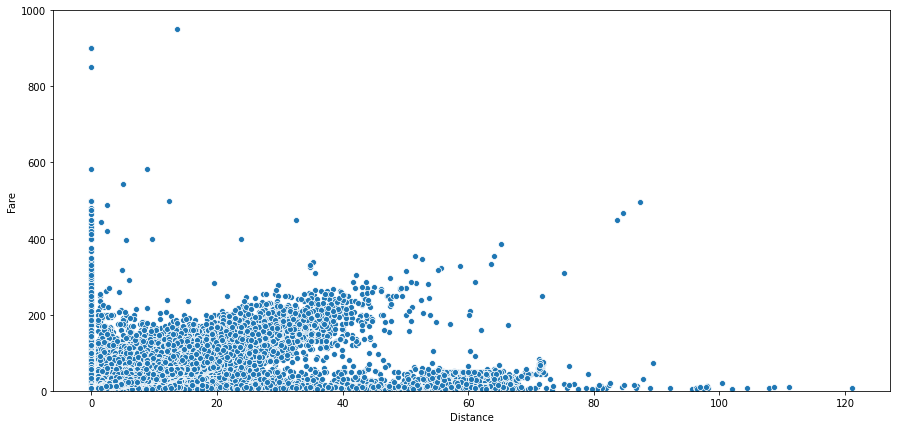

In [ ]:
plt.figure(figsize=(15,7))
sns.scatterplot(x=distance, y=fare_amount)
plt.ylim(0,1000)
plt.xlabel('Distance')
plt.ylabel('Fare')

Durch den Scatter Plot kann eine lineare Abhängikeit zwischen Fahrpreis und Distanz erkannt werden. Es bestehen zudem viele Trips die zwar länger sind aber weniger kosten, welche möglicherweise feste Preise hatten oder Reduzierungen. Was auch interessant ist, dass es anscheinend viele Fahrten gibt, die kaum eine Distanz haben. Es könnte sein, dass diese ein Roundtrip sind oder ähnliches.

### Datetime

In [ ]:
fare_amount = train_1['fare_amount'].to_array()
passenger_count = train_1['passenger_count'].to_array()
distance = train_1['distance_miles'].to_array()
hour = train_1["hour"].to_array()
weekday = train_1["weekday"].to_array()
month =train_1["month"].to_array()
year = train_1["year"].to_array()

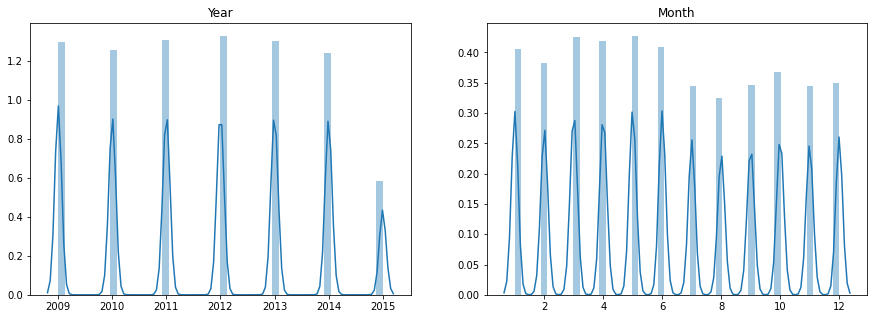

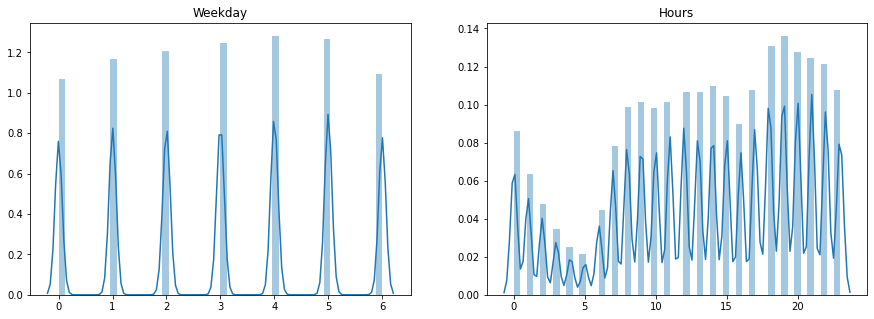

In [ ]:
fig,(ax1,ax2,)=plt.subplots(1,2,figsize=(15,5))
ax1.set_title('Year')
sns.distplot(year, ax=ax1)

ax2.set_title('Month')
sns.distplot(month, ax=ax2)
plt.show()

fig,(ax1,ax2,)=plt.subplots(1,2,figsize=(15,5))
ax1.set_title('Weekday')
sns.distplot(weekday, ax=ax1)

ax2.set_title('Hours')
sns.distplot(hour, ax=ax2)
plt.show()

Betrachtet man die Datetime erkennt man das in den Monaten von Juli bis Oktober weniger Fahrten getätigt wurden. Das könnte an dem besseren Wetter und mögliche Urlaube liegen, wo regelmäßige Taxifahrten nicht mehr stattfinden.
Die beschäftigsten Wochentage sind gegen das Wochenende und Stunden mit den meisten Fahrten liegen am Abend bis Mitternacht, wahrscheinlich da die meisetn Leute um diese Uhrzeit schnell nach Hause wollen oder auch selbst nicht mehr fahren oder laugen können durch Konsum von Alkohol.

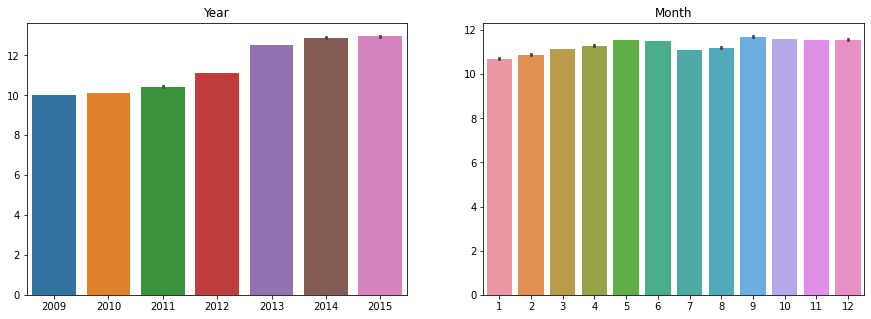

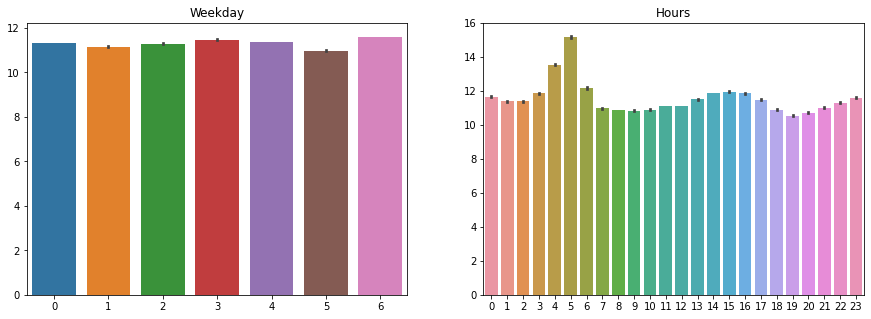

In [ ]:
fig,(ax1,ax2,)=plt.subplots(1,2,figsize=(15,5))
ax1.set_title('Year')
sns.barplot(x=year, y=fare_amount,ax=ax1)

ax2.set_title('Month')
sns.barplot(x=month, y=fare_amount,ax=ax2)
plt.show()

fig,(ax1,ax2,)=plt.subplots(1,2,figsize=(15,5))
ax1.set_title('Weekday')
sns.barplot(x=weekday, y=fare_amount,ax=ax1)

ax2.set_title('Hours')
sns.barplot(x=hour, y=fare_amount,ax=ax2)
plt.show()

Betrachtete man nun die Datetime mit Abhängigkeit auf die Fahrgebühren, sieht man das die Preise pro Jahr gestiegen sind. Die teuersten Monate sind von Mai bis Juni und September bis Dezember, welches wahrscheinlich dem Wetter geschuldet ist. Die teuersten Tage sind am Sonntag und Monatg und die teuersten Stunden sind die sehr frühren Morgenstunden von 4 bis 6 Uhr.

### Passenger Count


In [ ]:
fare_amount = train_1['fare_amount'].to_array()
passenger_count = train_1['passenger_count'].to_array()
distance = train_1['distance_miles'].to_array()
hour = train_1["hour"].to_array()
weekday = train_1["weekday"].to_array()
month =train_1["month"].to_array()
year = train_1["year"].to_array()

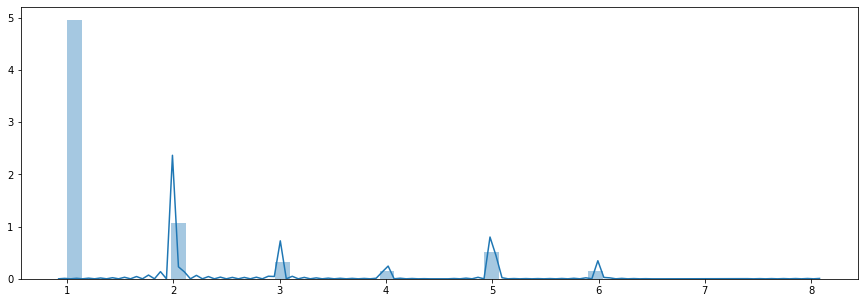

In [ ]:
plt.figure(figsize=(15,5))
sns.distplot(passenger_count)

Text(0, 0.5, 'Fahrgebühr')

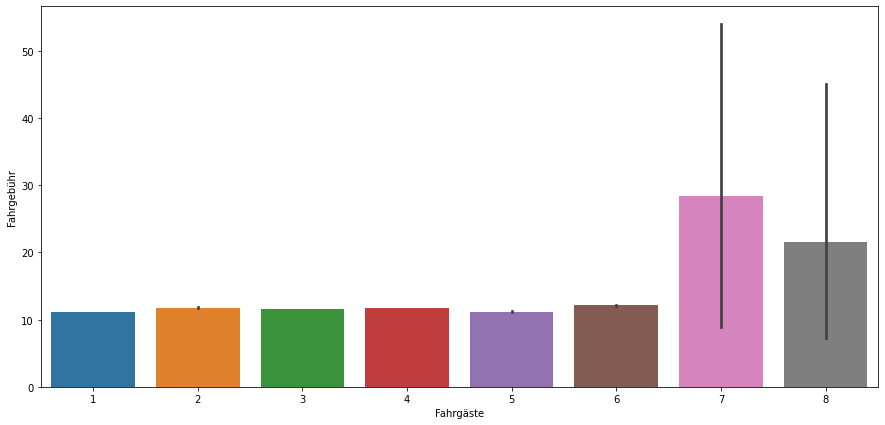

In [ ]:
plt.figure(figsize=(15,7))
sns.barplot(x=passenger_count, y=fare_amount)
plt.xlabel('Fahrgäste')
plt.ylabel('Fahrgebühr')

In [57]:
print("Shape of Training Data after cleaning data", train_1.shape)

Shape of Training Data after cleaning data (24391188, 12)


# Spalten entfernen die nicht mehr benötigt werden


Nachdem die Daten gesäubert und analysiert wurden, werden die nicht notwendigen Datenspalten entfernt. Es werden die Longitude und Latitude Felder entfernt, da diese in der neu berechneten Distanzspalte wiederfinden. Die Pickup_datetime Spalte wird auch entfernt, da diese auf ihre jeweiligen Komponenten aufgeteilt wurde. 

In [16]:
drop_columns = ['pickup_datetime','dropoff_latitude','pickup_latitude','dropoff_longitude','pickup_longitude']
train_1=train_1.drop(drop_columns,axis=1)
test_1=test_1.drop(drop_columns,axis=1)

In [24]:
train_1.head()

,fare_amount,passenger_count,hour,weekday,month,year,distance_miles
0,4.5,1,17,0,6,2009,0.000000
1,16.9,1,16,1,1,2010,5.244397
2,5.7,2,0,3,8,2011,0.000000
3,7.7,1,4,5,4,2012,1.932986
4,5.3,1,7,1,3,2010,1.366828


In [25]:
test_1.head()

,passenger_count,hour,weekday,month,year,distance_miles
0,1,13,1,1,2015,1.366828
1,1,13,1,1,2015,1.366828
2,1,11,5,10,2011,0.000000
3,1,21,5,12,2012,1.366828
4,1,21,5,12,2012,3.226874


# Training

In [17]:
def saveResults(y_pred, filename):
  gdf_submission = cudf.read_csv(base_path +'/sample_submission.csv')
  gdf_submission['fare_amount']= y_pred
  gdf_submission.to_csv(base_path + filename, index=False)
  return gdf_submission.head()

## Linear Regression

In [27]:
X=train_1.drop(['fare_amount'],axis=1)
y=train_1['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ", X_train.shape[0])
print("Number of records in validation data ", X_test.shape[0])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Number of records in training data  19508711
Number of records in validation data  4877177
(19508711, 6)
(4877177, 6)
(19508711,)
(4877177,)


In [28]:
lm = LinearRegression(fit_intercept = True, normalize = False,
                      algorithm = "eig")

lm.fit(X_train,y_train)
y_pred = lm.predict(X_test)
lm_rmse = r2_score(y_pred, y_test)

print("RMSE for Linear Regression is ", lm_rmse)

y_pred = lm.predict(test_1)
saveResults(y_pred, '/linearRegressionSubmission.csv')

RMSE for Linear Regression is  0.5179684162139893


,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.862732
1,2015-01-27 13:08:24.0000003,10.862732
2,2011-10-08 11:53:44.0000002,4.918030
3,2012-12-01 21:12:12.0000002,9.962463
4,2012-12-01 21:12:12.0000003,15.856079


Die Lineare Regression brachte bei Kaggel einen Score von 5.47739 womit es besser als das Basic Linear Model auf Kaggel ist, allerdings noch viel Verbesserungspotenzial zeigt.

## Ridge Regression


Für Ridge Regression wurde Hyperparameter Optimierung angewendet für die Parameter alpha und solver mit Hilfe von RandomizedSearchCV.
 

In [29]:
X=train_1.drop(['fare_amount'],axis=1)
y=train_1['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ",X_train.shape[0])
print("Number of records in validation data ",X_test.shape[0])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Number of records in training data  19508711
Number of records in validation data  4877177
(19508711, 6)
(4877177, 6)
(19508711,)
(4877177,)


In [30]:
params_ridge = {
    "alpha": loguniform(1e-5, 1e0), # default 1.0
    "solver": ['eig', 'cd'], 
}
ridge = Ridge()
clf = RandomizedSearchCV(ridge, params_ridge, random_state=1, n_iter=100, cv=5, verbose=0, n_jobs=1)
best_model = clf.fit(X_train,y_train)
best_model.best_estimator_.get_params()

{'alpha': 0.001216494146415184,
 'fit_intercept': True,
 'normalize': False,
 'solver': 'eig'}

In [31]:
ridge_params =  best_model.best_estimator_.get_params()

ridge = Ridge(**ridge_params)
result_ridge = ridge.fit(X_train,y_train)

y_pred = result_ridge.predict(X_test)
ridge_rmse = r2_score(y_pred, y_test)
print("RMSE for Ridge_rmse Regression is ", ridge_rmse)

y_pred = result_ridge.predict(test_1)
saveResults(y_pred, '/ridgeRegressionSubmission.csv')

RMSE for Ridge_rmse Regression is  0.5181183815002441


,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.861084
1,2015-01-27 13:08:24.0000003,10.861084
2,2011-10-08 11:53:44.0000002,4.924561
3,2012-12-01 21:12:12.0000002,9.965515
4,2012-12-01 21:12:12.0000003,15.854614


Bei der Ridge Regression wurde ein Kaggle Score von 5.47661, was eine minimale Verbesserung des vorherigen Scores ist. Da sich der Unterschied allerdings bei ca 0.001 liegt, kann kaum von einer wirklichen Verbesserung gesprochen werden. Die Ridge Regression bringt also nicht viel mehr als eine normale Lineare Regression.

## Lasso Regression


In [32]:
X=train_1.drop(['fare_amount'],axis=1)
y=train_1['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ",X_train.shape[0])
print("Number of records in validation data ",X_test.shape[0])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Number of records in training data  19508711
Number of records in validation data  4877177
(19508711, 6)
(4877177, 6)
(19508711,)
(4877177,)


In [33]:
params_lasso = {
    "alpha": loguniform(1e-5, 1e0),
    "max_iter": np.arange(start=500, stop = 3000, step = 500),
    "tol": loguniform(1e-5, 1e0), 
    "selection": ['cyclic', 'random'],
}

lasso = Lasso()
clf = RandomizedSearchCV(lasso, params_lasso, random_state=1, n_iter=1000, cv=5, verbose=0, n_jobs=1)
best_model = clf.fit(X_train,y_train) 
best_model.best_estimator_.get_params()

{'alpha': 0.001216494146415184,
 'fit_intercept': True,
 'max_iter': 2500,
 'normalize': False,
 'selection': 'cyclic',
 'tol': 1.0013176560941263e-05}

In [34]:
lasso_params = best_model.best_estimator_.get_params() 

lasso = Lasso(**lasso_params)
result_lasso = lasso.fit(X_train,y_train)
y_pred=result_lasso.predict(X_test)
lasso_rmse = r2_score(y_pred, y_test)
print("RMSE for Lasso Regression is ", lasso_rmse)

y_pred = result_lasso.predict(test_1)
saveResults(y_pred, '/lassoRegressionSubmission.csv')

RMSE for Lasso Regression is  0.5211814045906067


,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.863770
1,2015-01-27 13:08:24.0000003,10.863770
2,2011-10-08 11:53:44.0000002,4.922546
3,2012-12-01 21:12:12.0000002,9.965027
4,2012-12-01 21:12:12.0000003,15.856262


Bei der Lasso Regression wurde ein Kaggel Score 5.55506 erreicht, also im gleichen Bereich wie die vorherigen Regressions Modelle. Insgesamt kann gesagt werden das zwischen Linear, Ridge und Lasso kaum ein Unterschied festzustellen ist. Linear Regression bringt noch das beste Ergebnis.

## Random Forest Regression Model

Die Verwendung der RandomizedSearchCV für das Random Forest Regression Model führte leider zu ständigen Laufzeitabbrüchen und wurde so nicht verwendet. An sich wurde per Hand mit den Hyperparameter experimentiert

In [18]:
X=train_1.drop(['fare_amount'],axis=1)
y=train_1['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [19]:
cu_rf_params = {
    'n_estimators': 300,
    'max_depth': 16,
    'n_bins': 10
}

cu_rf = cuRF(**cu_rf_params)
cu_rf.fit(X_train, y_train)
y_pred=cu_rf.predict(X_test)

rf_rmse = r2_score(y_pred, y_test)
print("RMSE for RF Regression is ", rf_rmse)

y_pred = cu_rf.predict(test_1)
saveResults(y_pred, '/rfRegressionSubmission.csv')

RMSE for RF Regression is  0.34577471017837524


,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.722087
1,2015-01-27 13:08:24.0000003,9.722087
2,2011-10-08 11:53:44.0000002,5.838555
3,2012-12-01 21:12:12.0000002,8.793941
4,2012-12-01 21:12:12.0000003,17.610649


## XGBoost

In [20]:
X=train_1.drop(['fare_amount'],axis=1)
y=train_1['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [21]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalidation = xgb.DMatrix(X_test, label=y_test)

In [23]:
# More range 
params_xgb1={
    "min_child_weight" : np.arange(start=2, stop=12, step=2), # default = 1
    "max_depth": np.arange(start=3, stop = 10, step = 1), # Default = 6
}

params_xgb2={
    "gamma": np.arange(start=0, stop=0.5, step=0.1),
}

params_xgb3={
    "colsample_bytree": np.arange(start=0.4, stop=1, step=0.1),
    "subsample": np.arange(start=0.4, stop=1, step=0.1),
}
params_xgb4={
    "reg_alpha": [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
}

params_xgb5 = {
    "learning_rate":  [0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3], #default = 0.3
    "n_estimators": [100, 250, 500, 750, 1000]
}
y_cpu = y_train.to_array()
xgb_model = xgb.XGBRegressor(tree_method='gpu_hist')

clf = RandomizedSearchCV(xgb_model, params_xgb1, random_state=1, n_iter=100, cv=5, verbose=10, n_jobs=1)
best_model = clf.fit(X_train,y_cpu)
print(best_model.best_estimator_.get_params())

clf = RandomizedSearchCV(xgb_model, params_xgb2, random_state=1, n_iter=100, cv=5, verbose=10, n_jobs=1)
best_model = clf.fit(X_train,y_cpu)
print(best_model.best_estimator_.get_params())

clf = RandomizedSearchCV(xgb_model, params_xgb3, random_state=1, n_iter=100, cv=5, verbose=10, n_jobs=1)
best_model = clf.fit(X_train,y_cpu)
print(best_model.best_estimator_.get_params())

clf = RandomizedSearchCV(xgb_model, params_xgb4, random_state=1, n_iter=50, cv=5, verbose=10, n_jobs=1)
best_model = clf.fit(X_train,y_cpu)
print(best_model.best_estimator_.get_params())

clf = RandomizedSearchCV(xgb_model, params_xgb5, random_state=1, n_iter=100, cv=5, verbose=10, n_jobs=1)
best_model = clf.fit(X_train,y_cpu)
print(best_model.best_estimator_.get_params())

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 35 is smaller than n_iter=100. Running 35 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] min_child_weight=2, max_depth=3 .................................
[CV] ..... min_child_weight=2, max_depth=3, score=0.765, total=   4.9s
[CV] min_child_weight=2, max_depth=3 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV] ..... min_child_weight=2, max_depth=3, score=0.764, total=   4.8s
[CV] min_child_weight=2, max_depth=3 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.8s remaining:    0.0s


[CV] ..... min_child_weight=2, max_depth=3, score=0.765, total=   4.8s
[CV] min_child_weight=2, max_depth=3 .................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.6s remaining:    0.0s


[CV] ..... min_child_weight=2, max_depth=3, score=0.747, total=   4.8s
[CV] min_child_weight=2, max_depth=3 .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   19.4s remaining:    0.0s


[CV] ..... min_child_weight=2, max_depth=3, score=0.772, total=   4.8s
[CV] min_child_weight=4, max_depth=3 .................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.2s remaining:    0.0s


[CV] ..... min_child_weight=4, max_depth=3, score=0.765, total=   4.8s
[CV] min_child_weight=4, max_depth=3 .................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   29.0s remaining:    0.0s


[CV] ..... min_child_weight=4, max_depth=3, score=0.764, total=   4.8s
[CV] min_child_weight=4, max_depth=3 .................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   33.8s remaining:    0.0s


[CV] ..... min_child_weight=4, max_depth=3, score=0.765, total=   4.8s
[CV] min_child_weight=4, max_depth=3 .................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   38.6s remaining:    0.0s


[CV] ..... min_child_weight=4, max_depth=3, score=0.747, total=   4.8s
[CV] min_child_weight=4, max_depth=3 .................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   43.4s remaining:    0.0s


[CV] ..... min_child_weight=4, max_depth=3, score=0.771, total=   4.8s
[CV] min_child_weight=6, max_depth=3 .................................
[CV] ..... min_child_weight=6, max_depth=3, score=0.765, total=   4.7s
[CV] min_child_weight=6, max_depth=3 .................................
[CV] ..... min_child_weight=6, max_depth=3, score=0.764, total=   4.8s
[CV] min_child_weight=6, max_depth=3 .................................
[CV] ..... min_child_weight=6, max_depth=3, score=0.765, total=   4.8s
[CV] min_child_weight=6, max_depth=3 .................................
[CV] ..... min_child_weight=6, max_depth=3, score=0.747, total=   4.8s
[CV] min_child_weight=6, max_depth=3 .................................
[CV] ..... min_child_weight=6, max_depth=3, score=0.771, total=   4.8s
[CV] min_child_weight=8, max_depth=3 .................................
[CV] ..... min_child_weight=8, max_depth=3, score=0.765, total=   4.8s
[CV] min_child_weight=8, max_depth=3 .................................
[CV] .

[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed: 22.4min finished


{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': 0, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 6, 'missing': nan, 'monotone_constraints': '(0,0,0,0,0,0)', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None}
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 5 is smaller than n_iter=100. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] gamma=0.0 .......................................................
[CV] ........................... gamma=0.0, score=0.769, total=   7.2s
[CV] gamma=0.0 .......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


[CV] ........................... gamma=0.0, score=0.768, total=   7.2s
[CV] gamma=0.0 .......................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.4s remaining:    0.0s


[CV] ........................... gamma=0.0, score=0.769, total=   7.2s
[CV] gamma=0.0 .......................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.6s remaining:    0.0s


[CV] ........................... gamma=0.0, score=0.751, total=   7.2s
[CV] gamma=0.0 .......................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   28.8s remaining:    0.0s


[CV] ........................... gamma=0.0, score=0.776, total=   7.2s
[CV] gamma=0.1 .......................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.0s remaining:    0.0s


[CV] ........................... gamma=0.1, score=0.769, total=   7.2s
[CV] gamma=0.1 .......................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   43.2s remaining:    0.0s


[CV] ........................... gamma=0.1, score=0.768, total=   7.2s
[CV] gamma=0.1 .......................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   50.4s remaining:    0.0s


[CV] ........................... gamma=0.1, score=0.769, total=   7.2s
[CV] gamma=0.1 .......................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   57.6s remaining:    0.0s


[CV] ........................... gamma=0.1, score=0.751, total=   7.2s
[CV] gamma=0.1 .......................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.1min remaining:    0.0s


[CV] ........................... gamma=0.1, score=0.776, total=   7.2s
[CV] gamma=0.2 .......................................................
[CV] ........................... gamma=0.2, score=0.769, total=   7.2s
[CV] gamma=0.2 .......................................................
[CV] ........................... gamma=0.2, score=0.768, total=   7.2s
[CV] gamma=0.2 .......................................................
[CV] ........................... gamma=0.2, score=0.769, total=   7.2s
[CV] gamma=0.2 .......................................................
[CV] ........................... gamma=0.2, score=0.751, total=   7.2s
[CV] gamma=0.2 .......................................................
[CV] ........................... gamma=0.2, score=0.776, total=   7.2s
[CV] gamma=0.30000000000000004 .......................................
[CV] ........... gamma=0.30000000000000004, score=0.769, total=   7.2s
[CV] gamma=0.30000000000000004 .......................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.0min finished


{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0.0, 'gpu_id': 0, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '(0,0,0,0,0,0)', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] subsample=0.4, colsample_bytree=0.4 .............................
[CV] . subsample=0.4, colsample_bytree=0.4, score=0.765, total=   6.7s
[CV] subsample=0.4, colsample_bytree=0.4 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s


[CV] . subsample=0.4, colsample_bytree=0.4, score=0.764, total=   6.7s
[CV] subsample=0.4, colsample_bytree=0.4 .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.4s remaining:    0.0s


[CV] . subsample=0.4, colsample_bytree=0.4, score=0.765, total=   6.6s
[CV] subsample=0.4, colsample_bytree=0.4 .............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.0s remaining:    0.0s


[CV] . subsample=0.4, colsample_bytree=0.4, score=0.747, total=   6.6s
[CV] subsample=0.4, colsample_bytree=0.4 .............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   26.7s remaining:    0.0s


[CV] . subsample=0.4, colsample_bytree=0.4, score=0.772, total=   6.7s
[CV] subsample=0.5, colsample_bytree=0.4 .............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.4s remaining:    0.0s


[CV] . subsample=0.5, colsample_bytree=0.4, score=0.765, total=   7.1s
[CV] subsample=0.5, colsample_bytree=0.4 .............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   40.5s remaining:    0.0s


[CV] . subsample=0.5, colsample_bytree=0.4, score=0.764, total=   7.0s
[CV] subsample=0.5, colsample_bytree=0.4 .............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   47.5s remaining:    0.0s


[CV] . subsample=0.5, colsample_bytree=0.4, score=0.765, total=   7.1s
[CV] subsample=0.5, colsample_bytree=0.4 .............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   54.6s remaining:    0.0s


[CV] . subsample=0.5, colsample_bytree=0.4, score=0.747, total=   7.0s
[CV] subsample=0.5, colsample_bytree=0.4 .............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.0min remaining:    0.0s


[CV] . subsample=0.5, colsample_bytree=0.4, score=0.772, total=   7.1s
[CV] subsample=0.6, colsample_bytree=0.4 .............................
[CV] . subsample=0.6, colsample_bytree=0.4, score=0.765, total=   7.5s
[CV] subsample=0.6, colsample_bytree=0.4 .............................
[CV] . subsample=0.6, colsample_bytree=0.4, score=0.764, total=   7.4s
[CV] subsample=0.6, colsample_bytree=0.4 .............................
[CV] . subsample=0.6, colsample_bytree=0.4, score=0.765, total=   7.5s
[CV] subsample=0.6, colsample_bytree=0.4 .............................
[CV] . subsample=0.6, colsample_bytree=0.4, score=0.747, total=   7.4s
[CV] subsample=0.6, colsample_bytree=0.4 .............................
[CV] . subsample=0.6, colsample_bytree=0.4, score=0.772, total=   7.4s
[CV] subsample=0.7, colsample_bytree=0.4 .............................
[CV] . subsample=0.7, colsample_bytree=0.4, score=0.765, total=   7.8s
[CV] subsample=0.7, colsample_bytree=0.4 .............................
[CV] .

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 22.1min finished


{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8999999999999999, 'gamma': 0, 'gpu_id': 0, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '(0,0,0,0,0,0)', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.8999999999999999, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 8 is smaller than n_iter=50. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] reg_alpha=0 .....................................................
[CV] ......................... reg_alpha=0, score=0.769, total=   7.2s
[CV] reg_alpha=0 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s


[CV] ......................... reg_alpha=0, score=0.768, total=   7.2s
[CV] reg_alpha=0 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.4s remaining:    0.0s


[CV] ......................... reg_alpha=0, score=0.769, total=   7.2s
[CV] reg_alpha=0 .....................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.6s remaining:    0.0s


[CV] ......................... reg_alpha=0, score=0.751, total=   7.2s
[CV] reg_alpha=0 .....................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   28.8s remaining:    0.0s


[CV] ......................... reg_alpha=0, score=0.776, total=   7.2s
[CV] reg_alpha=0.001 .................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.0s remaining:    0.0s


[CV] ..................... reg_alpha=0.001, score=0.769, total=   7.2s
[CV] reg_alpha=0.001 .................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   43.2s remaining:    0.0s


[CV] ..................... reg_alpha=0.001, score=0.768, total=   7.1s
[CV] reg_alpha=0.001 .................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   50.3s remaining:    0.0s


[CV] ..................... reg_alpha=0.001, score=0.769, total=   7.2s
[CV] reg_alpha=0.001 .................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   57.5s remaining:    0.0s


[CV] ..................... reg_alpha=0.001, score=0.751, total=   7.1s
[CV] reg_alpha=0.001 .................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.1min remaining:    0.0s


[CV] ..................... reg_alpha=0.001, score=0.776, total=   7.2s
[CV] reg_alpha=0.005 .................................................
[CV] ..................... reg_alpha=0.005, score=0.769, total=   7.2s
[CV] reg_alpha=0.005 .................................................
[CV] ..................... reg_alpha=0.005, score=0.768, total=   7.1s
[CV] reg_alpha=0.005 .................................................
[CV] ..................... reg_alpha=0.005, score=0.769, total=   7.2s
[CV] reg_alpha=0.005 .................................................
[CV] ..................... reg_alpha=0.005, score=0.751, total=   7.2s
[CV] reg_alpha=0.005 .................................................
[CV] ..................... reg_alpha=0.005, score=0.776, total=   7.2s
[CV] reg_alpha=0.01 ..................................................
[CV] ...................... reg_alpha=0.01, score=0.769, total=   7.2s
[CV] reg_alpha=0.01 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  4.8min finished


{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': 0, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '(0,0,0,0,0,0)', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 1, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None}
Fitting 5 folds for each of 35 candidates, totalling 175 fits


/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 35 is smaller than n_iter=100. Running 35 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] n_estimators=100, learning_rate=0.05 ............................
[CV]  n_estimators=100, learning_rate=0.05, score=0.766, total=   8.0s
[CV] n_estimators=100, learning_rate=0.05 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s remaining:    0.0s


[CV]  n_estimators=100, learning_rate=0.05, score=0.765, total=   8.0s
[CV] n_estimators=100, learning_rate=0.05 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.0s remaining:    0.0s


[CV]  n_estimators=100, learning_rate=0.05, score=0.766, total=   7.9s
[CV] n_estimators=100, learning_rate=0.05 ............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.9s remaining:    0.0s


[CV]  n_estimators=100, learning_rate=0.05, score=0.748, total=   7.9s
[CV] n_estimators=100, learning_rate=0.05 ............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   31.8s remaining:    0.0s


[CV]  n_estimators=100, learning_rate=0.05, score=0.772, total=   7.9s
[CV] n_estimators=250, learning_rate=0.05 ............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   39.7s remaining:    0.0s


[CV]  n_estimators=250, learning_rate=0.05, score=0.768, total=  17.5s
[CV] n_estimators=250, learning_rate=0.05 ............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   57.2s remaining:    0.0s


[CV]  n_estimators=250, learning_rate=0.05, score=0.767, total=  17.5s
[CV] n_estimators=250, learning_rate=0.05 ............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.2min remaining:    0.0s


[CV]  n_estimators=250, learning_rate=0.05, score=0.768, total=  17.5s
[CV] n_estimators=250, learning_rate=0.05 ............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.5min remaining:    0.0s


[CV]  n_estimators=250, learning_rate=0.05, score=0.750, total=  17.4s
[CV] n_estimators=250, learning_rate=0.05 ............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.8min remaining:    0.0s


[CV]  n_estimators=250, learning_rate=0.05, score=0.775, total=  17.4s
[CV] n_estimators=500, learning_rate=0.05 ............................
[CV]  n_estimators=500, learning_rate=0.05, score=0.769, total=  31.7s
[CV] n_estimators=500, learning_rate=0.05 ............................
[CV]  n_estimators=500, learning_rate=0.05, score=0.768, total=  31.9s
[CV] n_estimators=500, learning_rate=0.05 ............................
[CV]  n_estimators=500, learning_rate=0.05, score=0.769, total=  32.0s
[CV] n_estimators=500, learning_rate=0.05 ............................
[CV]  n_estimators=500, learning_rate=0.05, score=0.751, total=  31.6s
[CV] n_estimators=500, learning_rate=0.05 ............................
[CV]  n_estimators=500, learning_rate=0.05, score=0.776, total=  32.0s
[CV] n_estimators=750, learning_rate=0.05 ............................
[CV]  n_estimators=750, learning_rate=0.05, score=0.769, total=  45.8s
[CV] n_estimators=750, learning_rate=0.05 ............................
[CV]  

[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed: 92.6min finished


{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': 0, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.075, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '(0,0,0,0,0,0)', 'n_estimators': 1000, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None}


 'max_depth': 7, 'min_child_weight': 6, 'gamma': 0.0, 
 
 'colsample_bytree': 0.9, 'subsample': 0.9,

'reg_alpha': 1

'learning_rate': 0.075,





In [24]:
# instantiate params
params = {}

# booster params
booster_params = {}

booster_params['tree_method'] = 'gpu_hist'
params.update(booster_params)

# learning task params
learning_task_params = {}
learning_task_params['eval_metric'] = 'rmse'
learning_task_params['objective'] = 'reg:squarederror'
params.update(learning_task_params)

params_xgb = {
    "max_depth": 7, # Default = 6
    "alpha" : 1, # default = 0
    "learning_rate":  0.075, #default = 0.3
    "min_child_weight" : 6, # default = 1
    'colsample_bytree': 0.9, 
    'subsample': 0.9,
    "n_estimators": 1000
}
params.update(params_xgb)

print(params)

{'tree_method': 'gpu_hist', 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'max_depth': 7, 'alpha': 1, 'learning_rate': 0.075, 'min_child_weight': 6, 'colsample_bytree': 0.9, 'subsample': 0.9, 'n_estimators': 1000}


In [25]:
# model training settings
evallist = [(dvalidation, 'validation'), (dtrain, 'train')]
num_round = 100

In [26]:
bst = xgb.train(params, dtrain, num_round, evallist)

[20:58:39] WARNING: /conda/conda-bld/xgboost_1591204502249/work/src/learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-rmse:13.60421	train-rmse:13.59054
[1]	validation-rmse:12.71800	train-rmse:12.70388
[2]	validation-rmse:11.90742	train-rmse:11.89284
[3]	validation-rmse:11.17340	train-rmse:11.15818
[4]	validation-rmse:10.49772	train-rmse:10.48198
[5]	validation-rmse:10.11257	train-rmse:10.09647
[6]	validation-rmse:9.77090	train-rmse:9.75447
[7]	validation-rmse:9.46878	train-rmse:9.45203
[8]	validation-rmse:8.94814	train-rmse:8.93086
[9]	validation-rmse:8.70688	train-rmse:8.68931
[10]	validation-rmse:8.25967	train-rmse:8.24159
[11]	validation-rmse:7.85657	train-rmse:7.83799
[12]	validation-rmse:7.49362	train-rmse:7.47455
[

In [27]:
dtest = xgb.DMatrix(test_1)
y_pred_xgb = bst.predict(dtest)
print(y_pred_xgb)

[ 9.64939    9.64939    5.6616755 ... 54.87977   22.591255   6.163408 ]


In [28]:
gdf_submission = cudf.read_csv(base_path +'/sample_submission.csv')
gdf_submission['fare_amount']= y_pred_xgb

gdf_submission.to_csv(base_path + '/XGBBoostSubmission.csv',index=False)
gdf_submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.649390
1,2015-01-27 13:08:24.0000003,9.649390
2,2011-10-08 11:53:44.0000002,5.661675
3,2012-12-01 21:12:12.0000002,8.788036
4,2012-12-01 21:12:12.0000003,16.150522


## SVR

Bei der Verwendung von SVR tauchte das Problem der Speicherverwendung auf. Deswegen werden nur 2000000 Milionen Datensätze verwendet. 

In [68]:
X=train_1.drop(['fare_amount'],axis=1)[:2000000]
y=train_1['fare_amount'][:2000000]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [67]:
svr = SVR(kernel='rbf', gamma='scale', C=10, epsilon=0.1, cache_size=1000)

result = svr.fit(X_train,y_train)
y_pred = result.predict(X_test)
svr_rmse = r2_score(y_pred, y_test)
print("RMSE for SVR Regression is ", svr_rmse)

y_pred = result.predict(test_1)
saveResults(y_pred, '/svrSubmissionC10.csv')

RMSE for SVR Regression is  -7.2666015625


,key,fare_amount
0,2015-01-27 13:08:24.0000002,8.904545
1,2015-01-27 13:08:24.0000003,8.904545
2,2011-10-08 11:53:44.0000002,7.050541
3,2012-12-01 21:12:12.0000002,8.784977
4,2012-12-01 21:12:12.0000003,10.842625
